# ELASTICC2 classifier training

## Step 1: Import enough high-SNR samples per type 

In [1]:
import glob, os
import numpy as np
from superphot_plus.lightcurve import Lightcurve
from superphot_plus.format_data_ztf import tally_each_class

In [2]:
labels_to_classes = {
    "SNIa-SALT3": 10,
    "SNIa-91bg": 11,
    "SNIax": 12,
    "SNIb": 20,
    "SNIb-host": 21,
    "SNIcBL-host": 27,
    "SNIc": 25,
    "SNIc-host": 26,
    "SNII-NMF": 30,
    "SNII": 31,
    "SNII-host": 32,
    "SNIIn": 35,
    "SNIIn-host": 36,
    "SNIIb-host": 37,
    "SLSNI-host": 40,
    "TDE": 42,
    "ILOT": 45,
    "CART": 46,
    "KN-K17": 50,
    "KN-B19": 51,
    "PISN": 59,
    "CLAGN": 60,
    "RRL": 80,
    "Mdwarf": 82,
    "EB": 83,
    "dwarf-nova": 84,
    "uLens-single": 87,
    "uLens-single2": 88,
    "uLens-binary": 89,
    "Cepheid": 90,
    "DSCT": 91,
}
classes_to_labels = {labels_to_classes[x] : x for x in labels_to_classes}

generic_label_matching = {
    "SNIa-SALT3": "SN Ia",
    "SNIa-91bg": "SN Ia",
    "SNIax": "SN Iax",
    "SNIb": "SN Ibc",
    "SNIb-host": "SN Ibc",
    "SNIcBL-host": "SN Ibc",
    "SNIc": "SN Ibc",
    "SNIc-host": "SN Ibc",
    "SNII-NMF": "SN II",
    "SNII": "SN II",
    "SNII-host": "SN II",
    "SNIIn": "SN II",
    "SNIIn-host": "SN II",
    "SNIIb-host": "SN II",
    "SLSNI-host": "SLSN",
    "TDE": "TDE",
    "ILOT": "ILOT",
    "CART": "CART",
    "KN-K17": "KN",
    "KN-B19": "KN",
    "PISN": "PISN",
    "CLAGN": "CLAGN",
    "RRL": "RRL",
    "Mdwarf": "Mdwarf",
    "EB": "EB",
    "dwarf-nova": "Dwarf nova",
    "uLens-single": "uLens",
    "uLens-single2": "uLens",
    "uLens-binary": "uLens",
    "Cepheid": "Cepheid",
    "DSCT": "DSCT",
}
labels_to_classes_elasticc = {
    "SNIa": [10, 11],
    "SNIbc": [20, 21, 25, 26, 27],
    "SNII": [31, 32, 35, 36],
    
}

In [3]:
data_dir = "../../../../elasticc2_data/elasticc2_dataset_preprocessed"
all_lc_files = glob.glob(os.path.join(data_dir, "*", "*.npz"))

lcs = []
classes = []
for lc_fn in all_lc_files:
    lc = Lightcurve.from_file(lc_fn)
    if lc.times is None:
        continue
    lcs.append(lc)
    c = int(lc.sn_class)
    if c not in classes and c not in classes_to_labels:
        print(lc_fn, c)
    classes.append(c)

labels = [classes_to_labels[x] for x in classes]
labels_general = [generic_label_matching[x] for x in labels]
tally_each_class(labels_general)

PISN: 2038
CLAGN: 2454
SN Ia: 2771
SN Ibc: 3586
CART: 171
SN II: 5617
KN: 7
EB: 1609
uLens: 508
DSCT: 722
TDE: 1613
SN Iax: 532
Mdwarf: 8
Cepheid: 479
SLSN: 2006
RRL: 495
ILOT: 219
Dwarf nova: 146



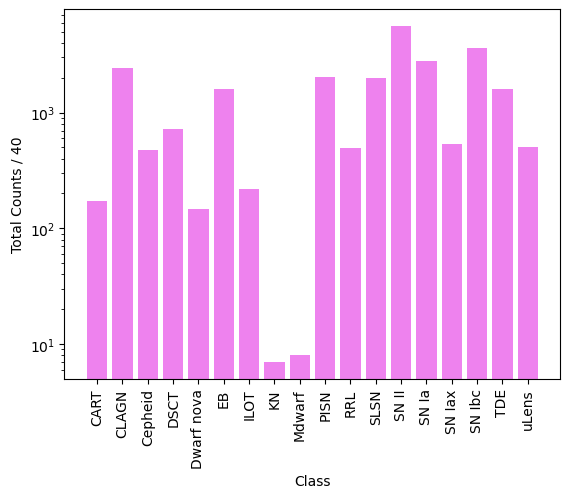

In [4]:
# make data histogram
import matplotlib.pyplot as plt
labels_unique, label_cts = np.unique(labels_general, return_counts=True)
plt.bar(labels_unique, label_cts, color="violet")
plt.yscale("log")
plt.ylabel("Total Counts / 40")
plt.xlabel("Class")
plt.xticks(rotation=90)
plt.show()

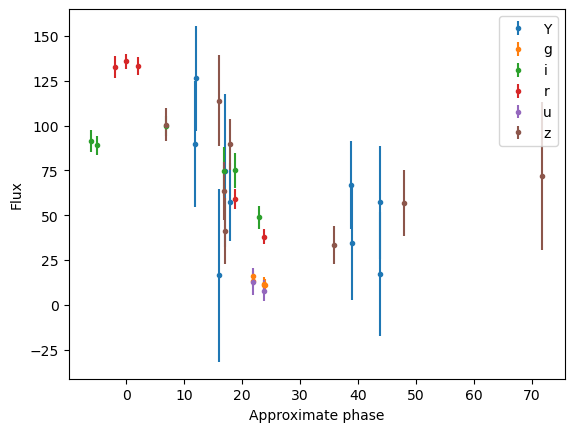

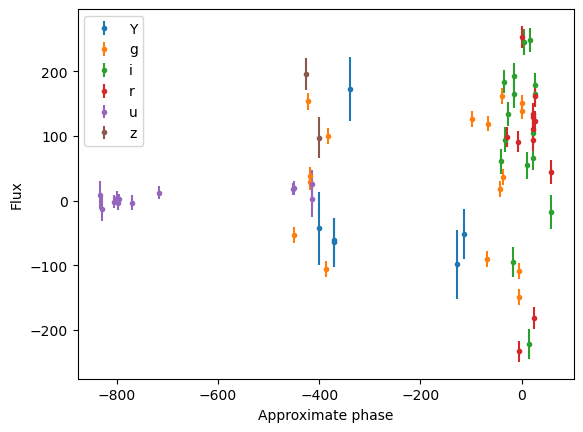

In [5]:
import matplotlib.pyplot as plt

# plot some light curves
Ia_lc_fn = glob.glob(os.path.join(data_dir, "ELASTICC2_TRAIN_02_SNIa-SALT3", "*.npz"))[0]
Ia_lc = Lightcurve.from_file(Ia_lc_fn)
for unique_b in np.unique(Ia_lc.bands):
    idxs = Ia_lc.bands == unique_b
    plt.errorbar(
        Ia_lc.times[idxs],
        Ia_lc.fluxes[idxs],
        yerr=Ia_lc.flux_errors[idxs],
        fmt=".",
        label=unique_b
    )
plt.xlabel("Approximate phase")
plt.ylabel("Flux")
plt.legend()
plt.show()


# plot some light curves
eb_lc_fn = glob.glob(os.path.join(data_dir, "ELASTICC2_TRAIN_02_EB", "*.npz"))[1]
eb_lc = Lightcurve.from_file(eb_lc_fn)
for unique_b in np.unique(eb_lc.bands):
    idxs = eb_lc.bands == unique_b
    plt.errorbar(
        eb_lc.times[idxs],
        eb_lc.fluxes[idxs],
        yerr=eb_lc.flux_errors[idxs],
        fmt=".",
        label=unique_b
    )
plt.xlabel("Approximate phase")
plt.ylabel("Flux")
plt.legend()
plt.show()

In [6]:
from superphot_plus.samplers.numpyro_sampler import NumpyroSampler
from superphot_plus.surveys.surveys import Survey

import time
# benchmark fitting
svi_sampler = NumpyroSampler()
survey = Survey.LSST()
priors = survey.priors

"""
#make sure fitting is working
all_band_fits = svi_sampler.run_single_curve(
    Ia_lc,
    priors,
    None
)
"""

'\n#make sure fitting is working\nall_band_fits = svi_sampler.run_single_curve(\n    Ia_lc,\n    priors,\n    None\n)\n'

In [7]:
from superphot_plus.plotting.lightcurves import plot_sampling_lc_fit
"""
band_fit_order = ["r", "i", "z", "g", "Y", "u"]
runtimes = []
red_chisqs = []
for i in range(2, 7):
    bands_include = band_fit_order[:i]
    lc_snipped = Ia_lc.filter_by_band(bands_include, in_place=False)
    prior_snipped = priors.filter_by_band(bands_include, in_place=False)
    start_time = time.time()
    snipped_fits = svi_sampler.run_multi_curve(
        [lc_snipped,]*20,
        prior_snipped,
        None
    )[0]
    ignore_idxs = lc_snipped.flux_errors == 1e10
    plot_sampling_lc_fit(
        str(lc_snipped.name)+"_"+str(len(bands_include)),
        ".",
        lc_snipped.times[~ignore_idxs],
        lc_snipped.fluxes[~ignore_idxs],
        lc_snipped.flux_errors[~ignore_idxs],
        lc_snipped.bands[~ignore_idxs],
        snipped_fits.samples,
        prior_snipped.band_order,
        prior_snipped.reference_band,
        sampling_method="svi",
        file_type="pdf",
        custom_formatting=None,
    )
    # best-fit params
    print(np.mean(snipped_fits.samples, axis=0))
    runtimes.append(time.time() - start_time)
    red_chisqs.append(np.mean(snipped_fits.samples[:,-1]))
"""

'\nband_fit_order = ["r", "i", "z", "g", "Y", "u"]\nruntimes = []\nred_chisqs = []\nfor i in range(2, 7):\n    bands_include = band_fit_order[:i]\n    lc_snipped = Ia_lc.filter_by_band(bands_include, in_place=False)\n    prior_snipped = priors.filter_by_band(bands_include, in_place=False)\n    start_time = time.time()\n    snipped_fits = svi_sampler.run_multi_curve(\n        [lc_snipped,]*20,\n        prior_snipped,\n        None\n    )[0]\n    ignore_idxs = lc_snipped.flux_errors == 1e10\n    plot_sampling_lc_fit(\n        str(lc_snipped.name)+"_"+str(len(bands_include)),\n        ".",\n        lc_snipped.times[~ignore_idxs],\n        lc_snipped.fluxes[~ignore_idxs],\n        lc_snipped.flux_errors[~ignore_idxs],\n        lc_snipped.bands[~ignore_idxs],\n        snipped_fits.samples,\n        prior_snipped.band_order,\n        prior_snipped.reference_band,\n        sampling_method="svi",\n        file_type="pdf",\n        custom_formatting=None,\n    )\n    # best-fit params\n    prin

In [8]:
runtimes_single = [] 
"""
for i in range(2, 7):
    bands_include = band_fit_order[:i]
    lc_snipped = Ia_lc.filter_by_band(bands_include)
    prior_snipped = priors.filter_by_band(bands_include, in_place=False)
    start_time = time.time()
    svi_sampler.run_single_curve(
        lc_snipped,
        prior_snipped,
        None
    )
    runtimes_single.append(time.time() - start_time)
"""

'\nfor i in range(2, 7):\n    bands_include = band_fit_order[:i]\n    lc_snipped = Ia_lc.filter_by_band(bands_include)\n    prior_snipped = priors.filter_by_band(bands_include, in_place=False)\n    start_time = time.time()\n    svi_sampler.run_single_curve(\n        lc_snipped,\n        prior_snipped,\n        None\n    )\n    runtimes_single.append(time.time() - start_time)\n'

In [9]:
"""
plt.scatter(np.arange(len(runtimes))+2, runtimes, label="50 iterations")
plt.scatter(np.arange(len(runtimes_single))+2, runtimes_single, label="Single iteration")
plt.ylabel("Seconds")
plt.xlabel("Number of bands")
plt.legend()
plt.show()
"""

'\nplt.scatter(np.arange(len(runtimes))+2, runtimes, label="50 iterations")\nplt.scatter(np.arange(len(runtimes_single))+2, runtimes_single, label="Single iteration")\nplt.ylabel("Seconds")\nplt.xlabel("Number of bands")\nplt.legend()\nplt.show()\n'

In [ ]:
# run fitting on all SN-like objects
data_dir = "../../../../elasticc2_data/elasticc2_dataset_preprocessed"
fits_dir = "../../../../elasticc2_data/elasticc2_sn_fits"

sn_subdirs = glob.glob(os.path.join(data_dir, "*"))
"""
sn_subdirs = [
    "ELASTICC2_TRAIN_02_SLSN-I_no_host",
    "ELASTICC2_TRAIN_02_SLSN-I+host",
    "ELASTICC2_TRAIN_02_SNIa-91bg",
    "ELASTICC2_TRAIN_02_SNIa-SALT3",
    "ELASTICC2_TRAIN_02_SNIax",
    "ELASTICC2_TRAIN_02_SNIb-Templates",
    "ELASTICC2_TRAIN_02_SNIc-Templates",
    "ELASTICC2_TRAIN_02_SNIc+HostXT_V19",
    "ELASTICC2_TRAIN_02_SNIcBL+HostXT_V19",
    "ELASTICC2_TRAIN_02_SNII-NMF",
    "ELASTICC2_TRAIN_02_SNII-Templates",
    "ELASTICC2_TRAIN_02_SNII+HostXT_V19",
    "ELASTICC2_TRAIN_02_SNIIb+HostXT_V19",
    "ELASTICC2_TRAIN_02_SNIIn-MOSFIT",
    "ELASTICC2_TRAIN_02_SNIIn+HostXT_V19",
]
"""
for sn_subdir in sn_subdirs:
    lcs_sn = []
    all_lc_files = glob.glob(
        os.path.join(sn_subdir, "*.npz")
    )
    fits_dir_full = os.path.join(fits_dir, sn_subdir.split("/")[-1])
    os.makedirs(fits_dir_full, exist_ok=True)
    for lc_fn in all_lc_files:
        lc = Lightcurve.from_file(lc_fn)
        if lc.times is None:
            continue
        if len(lc.fluxes[lc.bands == priors.reference_band]) == 0:
            print("no r points")
            continue
        if os.path.exists(
            os.path.join(fits_dir_full, str(lc.name)+"_eqwt_svi.npz")
        ):
            continue
        lcs_sn.append(lc)
    snipped_fits = svi_sampler.run_multi_curve(
        lcs_sn,
        priors,
        None
    )
    for snipped_fit in snipped_fits:
        snipped_fit.save_to_file(fits_dir_full)
    

no r points
Running numpyro with seed=1685524938
0


/Users/kdesoto/python_repos/superphot-plus/src/superphot_plus/utils.py:222: RuntimeWarning: overflow encountered in exp
  / (1.0 + np.exp(-phase_b / tau_rise_b))
/Users/kdesoto/python_repos/superphot-plus/src/superphot_plus/utils.py:224: RuntimeWarning: overflow encountered in exp
  * np.exp((gamma_b - phase_b) / tau_fall_b)
/Users/kdesoto/python_repos/superphot-plus/src/superphot_plus/utils.py:443: RuntimeWarning: overflow encountered in square
  np.log(1.0 / np.sqrt(2.0 * np.pi * sigma_sq)) - 0.5 * (f - model_f) ** 2 / sigma_sq, axis=1


100


/Users/kdesoto/python_repos/superphot-plus/src/superphot_plus/utils.py:199: RuntimeWarning: overflow encountered in exp
  amp / (1.0 + np.exp(-phase / tau_rise)) * (1.0 - beta * gamma) * np.exp((gamma - phase) / tau_fall)
/Users/kdesoto/python_repos/superphot-plus/src/superphot_plus/utils.py:202: RuntimeWarning: overflow encountered in exp
  amp / (1.0 + np.exp(-phase[phase < gamma] / tau_rise)) * (1.0 - beta * phase[phase < gamma])
/Users/kdesoto/python_repos/superphot-plus/src/superphot_plus/utils.py:227: RuntimeWarning: overflow encountered in exp
  amp_b / (1.0 + np.exp(-phase_b2 / tau_rise_b)) * (1.0 - phase_b2 * beta_b)


200
300
400
500
600
700
800
900
1000
1100
1200
1300


/Users/kdesoto/python_repos/superphot-plus/src/superphot_plus/utils.py:221: RuntimeWarning: invalid value encountered in multiply
  amp_b


1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
Running numpyro with seed=2032026183
0


2023-09-21 18:10:07.110137: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 34m42.34125s

********************************
[Compiling module jit_lax_helper_function] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************


100
Running numpyro with seed=156336748
0


2023-09-21 22:10:39.234358: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 32m38.206884s

********************************
[Compiling module jit_lax_helper_function] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************


100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
Running numpyro with seed=3183739721
0


In [ ]:
# add period information
from top_level_classifier import estimate_period
all_lc_files = glob.glob(os.path.join(data_dir, "*", "*.npz"))

for i, lc_fn in enumerate(all_lc_files):
    if i % 1000 == 0:
        print(i)
    lc = Lightcurve.from_file(lc_fn)
    if 'period' in lc.extra_properties:
        continue
    period = estimate_period(
         lc.times,
         lc.fluxes,
         lc.flux_errors,
         lc.bands
     )
    period_long = estimate_period(
        lc.times,
        lc.fluxes,
        lc.flux_errors,
        lc.bands,
        5
    )
    lc.extra_properties['period'] = period
    lc.extra_properties['period_long'] = period_long
    lc.save_to_file(lc_fn, overwrite=True) 

In [ ]:
# train top level model
from top_level_classifier import *
X_true, y_true, y_probs, metrics = train_top_level_model(lcs, priors)

In [ ]:
# plot confusion matrix + metrics
from superphot_plus.plotting.confusion_matrices import plot_confusion_matrix

y_pred = np.argmax(y_probs, axis=1)

plt.rc("font", size=4)  # controls default text sizes
plt.rc("axes", titlesize=8)  # fontsize of the axes title
plt.rc("axes", labelsize=8)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=4)  # fontsize of the tick labels
plt.rc("ytick", labelsize=4)  # fontsize of the tick labels
plt.rc("legend", fontsize=8)  # legend fontsize
plt.rc("figure", titlesize=8)  # fontsize of the figure title

fig_labels = [
    "Ia", "Ibc", "II", "Iax", "91bg",
    "KN", "M-dwarf-Flare", "Dwarf-Novae", "uLens",
    "SLSN", "TDE", "ILOT", "CART", "PISN",
    "Cepheid", "RR-Lyrae", "Delta-Scuti", "EB",
    "LPV/Mira", "AGN"
]

y_true_labels = [fig_labels[i] for i in y_true]
y_pred_labels = [fig_labels[i] for i in y_pred]
    
plot_confusion_matrix(
    y_true_labels,
    y_pred_labels,
    "cm_top_level.pdf",
    purity=False,
    cmap="Purples"
)

